<a href="https://colab.research.google.com/github/Fraanas/BrainTumors/blob/main/imageGenerator%5B1%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Introduction

In this notebook I will create new data for my models by using data augmentation and generation by GAN models.

Here will be sth more...

## Imports

In [24]:
import shutil
from pathlib import Path
import os
import zipfile
import gdown
import pickle

import numpy as np
import math
from matplotlib import pyplot as plt
import matplotlib
import matplotlib.animation as animation
from IPython.display import HTML


import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import ImageFolder
from torchvision.datasets.folder import default_loader
import torchvision.transforms as T
from torch import optim
from torchvision import utils

### Set device

In [2]:
# Setting device
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
  device = "mps"
elif torch.device("cpu"):
  device = "cpu"

print("The type of devise: ", device)
print("The version of torch:", torch.__version__)

The type of devise:  cpu
The version of torch: 2.6.0+cu124


## Loading and Preprocessing Data

In [3]:
def extract_gdrive_file(folder_id, output_path):
    '''
    Download and extract a ZIP file from Google Drive.
    Parameters:
    - folder_id (str): The unique ID of the file from G Drive link.
    - output_path (str): The path where the files will be extracted.
    '''
    # check whether the data already exists
    if os.path.exists(output_path) and len(os.listdir(output_path)) > 0:
        print("Data already exists. I'm skipping the downloading and unpacking.")
        return

    # create file for extracted files, if not existed
    if not os.path.exists(output_path):
        os.makedirs(output_path)

    # download file from Google Drive
    zip_url = f"https://drive.google.com/uc?export=download&id={folder_id}"
    zip_filename = os.path.join(output_path, "brain_tumors_img.zip")
    print(f"Downloading file from Google Drive to {zip_filename}...")
    gdown.download(zip_url, zip_filename, quiet=False)

    # extract the file to output path
    print(f"Unzipping file: {zip_filename}...")
    try:
        with zipfile.ZipFile(zip_filename, "r") as zip_ref:
            zip_ref.extractall(output_path)
        print("Unzipping of the file is complete!")
    except zipfile.BadZipFile:
        print("Error: The downloaded file is not a valid ZIP archive.")
        return

    # delete zip file after extraction
    os.remove(zip_filename)
    print("ZIP file has been removed!")

    # Remove the _MACOSX folder if exists
    macosx_path = os.path.join(output_path, '__MACOSX')
    if os.path.exists(macosx_path):
        shutil.rmtree(macosx_path)
        print("_MACOSX folder has been removed!")

    # Remove .DS_Store files from the extracted folders
    for root, dirs, files in os.walk(output_path):
        for file in files:
            if file == ".DS_Store":
                file_path = os.path.join(root, file)
                os.remove(file_path)
                print(f"Removed file: {file_path}")



FOLDER_ID = "1xHeIOOHUFlnTxuSJzwuoVMmb3iz-oHlB"
OUTPUT_PATH = "./data/tumors"
extract_gdrive_file(FOLDER_ID, OUTPUT_PATH)

Downloading...
From (original): https://drive.google.com/uc?export=download&id=1xHeIOOHUFlnTxuSJzwuoVMmb3iz-oHlB
From (redirected): https://drive.google.com/uc?export=download&id=1xHeIOOHUFlnTxuSJzwuoVMmb3iz-oHlB&confirm=t&uuid=bb7b9e2a-abbd-40de-a254-78c1e7479d4d
To: /content/data/tumors/brain_tumors_img.zip
100%|██████████| 159M/159M [00:01<00:00, 96.5MB/s]


Unzipping file: ./data/tumors/brain_tumors_img.zip...
Unzipping of the file is complete!
ZIP file has been removed!
_MACOSX folder has been removed!
Removed file: ./data/tumors/brain_tumors_img/.DS_Store
Removed file: ./data/tumors/brain_tumors_img/Testing/.DS_Store
Removed file: ./data/tumors/brain_tumors_img/Training/.DS_Store


In [4]:
# directories for images
TRAIN_DIR = Path('data/tumors/brain_tumors_img/Training')
TEST_DIR  = Path('data/tumors/brain_tumors_img/Testing')

# directories for generating images with GANs
GLIOMA_TRAIN_GAN_DIR     = Path('data/tumors/brain_tumors_img/Training/glioma')
MENINGIOMA_TRAIN_GAN_DIR = Path('data/tumors/brain_tumors_img/Training/meningioma')
PITUITARY_TRAIN_GAN_DIR  = Path('data/tumors/brain_tumors_img/Training/pituitary')
NOTUMOR_TRAIN_GAN_DIR    = Path('data/tumors/brain_tumors_img/Training/notumor')

In [5]:
# create folders for new images and models
def create_folder(dst):
  if not os.path.exists(dst):
        os.makedirs(dst)
        print(f'Folder {dst} has been created.')
  else:
        print(f'Folder {dst} already exists.')

create_folder('data/eachEpochImages')
create_folder('models/GAN')
create_folder('models/tumor_classifier')
create_folder('other/gif')
create_folder('data/tumors/brain_tumor_img/Training_aug')

Folder data/eachEpochImages has been created.
Folder models/GAN has been created.
Folder models/tumor_classifier has been created.
Folder other/gif has been created.
Folder data/tumors/brain_tumor_img/Training_aug has been created.


In [6]:
# TODO: will delate later probably
'''
# directories for images
TRAIN_DIR = Path('data/tumors/brain_tumors_img/Training')
TEST_DIR = Path('data/tumors/brain_tumors_img/Testing')
TRAIN_GAN_DIR = Path('data/tumors/brain_tumors_img/TrainingGAN')

os.makedirs(TRAIN_GAN_DIR, exist_ok=True)

def copy_contents(src1,src2, dst):
    if not os.path.exists(dst):
        os.makedirs(dst)
        print(f'Folder {dst} has been created.')
    else:
        print(f'Folder {dst} already exists.')

    def copy_images(src):
        for image in os.listdir(src):
            s = os.path.join(src, image)
            d = os.path.join(dst, image)
            if os.path.isdir(s):
                shutil.copytree(s, d, dirs_exist_ok=True)
                print(f"Copied folder: {s} -> {d}")
            else:
                shutil.copy2(s, d)
                print(f"Copied images: {s} -> {d}")

    # Merge images from training dataset and testing dataset folders
    copy_images(src1)
    copy_images(src2)
    print(f"Images from: {src1} and {src2} are merged and saved in {dst}")

copy_contents(TRAIN_DIR, TEST_DIR, TRAIN_GAN_DIR)
'''

'\n# directories for images\nTRAIN_DIR = Path(\'data/tumors/brain_tumors_img/Training\')\nTEST_DIR = Path(\'data/tumors/brain_tumors_img/Testing\')\nTRAIN_GAN_DIR = Path(\'data/tumors/brain_tumors_img/TrainingGAN\')\n\nos.makedirs(TRAIN_GAN_DIR, exist_ok=True)\n\ndef copy_contents(src1,src2, dst):\n    if not os.path.exists(dst):\n        os.makedirs(dst)\n        print(f\'Folder {dst} has been created.\')\n    else:\n        print(f\'Folder {dst} already exists.\')\n\n    def copy_images(src):\n        for image in os.listdir(src):\n            s = os.path.join(src, image)\n            d = os.path.join(dst, image)\n            if os.path.isdir(s):\n                shutil.copytree(s, d, dirs_exist_ok=True)\n                print(f"Copied folder: {s} -> {d}")\n            else:\n                shutil.copy2(s, d)\n                print(f"Copied images: {s} -> {d}")\n\n    # Merge images from training dataset and testing dataset folders\n    copy_images(src1)\n    copy_images(src2)\n    

In [7]:
nb_gpu = 1
image_size = 64 # 64 is better than
nb_channels = 3 # For RGB images
batch_size = 64
num_workers = 0
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

- **nb_gpu = 1** -> number of GPUs
- **image_size = 64** -> it's size of image, which performs better with DCGAN network architecture than 224x224
- **nb_channels = 3** -> number of channels (RGB = 3 channels)
- **batch_size = 64** -> size of the batch
- **stats** -> used for normalize the images

### Set device

In [8]:
def get_default_device():
    """Pick GPU or MPS if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device("cuda")
    elif torch.backends.mps.is_available():
        return torch.device("mps")
    else:
         return torch.device("cpu")

def to_device(data, device):
    """Move tensors to chosen device"""
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)


class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """"Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [9]:
device = get_default_device()
device

device(type='cpu')

Since, we will be generating each class separately, and ImageFolder requires the labeled class in the folder, I will create a SingleImageDataset class to handle datasets with only one class.

In [10]:
class SingleClassImageDataset(Dataset):
  def __init__(self, folder_path, transform=None):
    self.paths = list(Path(folder_path).glob("*"))
    self.transform = transform
    self.loader = default_loader

  def __len__(self):
    return len(self.paths)

  def __getitem__(self, index):
    img = self.loader(self.paths[index])
    if self.transform:
      img = self.transform(img)
    return img, 0

### Dataset and Data Loader

In [11]:
# basic train dataset and dataloader for data augmentation
train_dataset = ImageFolder(TRAIN_DIR, transform=T.Compose([
    T.Resize((image_size, image_size)),
    T.CenterCrop(image_size),
    T.ToTensor(),
    T.Normalize(*stats),
]))

train_dataloader = DataLoader(train_dataset,
                              batch_size=batch_size,
                              shuffle=True,
                              num_workers=num_workers,
                              pin_memory=True)


# dataset and dataloader for generate images: glioma type tumors with GANs
train_glioma_dataset = SingleClassImageDataset(GLIOMA_TRAIN_GAN_DIR, transform=T.Compose([
    T.Resize((image_size, image_size)),
    T.CenterCrop(image_size),
    T.ToTensor(),
    T.Normalize(*stats),
]))

train_glioma_dataloader = DataLoader(train_glioma_dataset,
                                     batch_size=batch_size,
                                     shuffle=True,
                                     num_workers=num_workers,
                                     pin_memory=True)

# dataset and dataloader for generate images: meningioma type tumors with GANs
train_meningioma_dataset = SingleClassImageDataset(MENINGIOMA_TRAIN_GAN_DIR, transform=T.Compose([
    T.Resize((image_size, image_size)),
    T.CenterCrop(image_size),
    T.ToTensor(),
    T.Normalize(*stats),
]))

train_meningioma_dataloader = DataLoader(train_meningioma_dataset,
                                         batch_size=batch_size,
                                         shuffle=True,
                                         num_workers=num_workers,
                                         pin_memory=True)

# dataset and dataloader for generate images: notumor type tumors with GANs
train_notumor_dataset = SingleClassImageDataset(NOTUMOR_TRAIN_GAN_DIR, transform=T.Compose([
    T.Resize((image_size, image_size)),
    T.CenterCrop(image_size),
    T.ToTensor(),
    T.Normalize(*stats),
]))

train_notumor_dataloader = DataLoader(train_notumor_dataset,
                                      batch_size=batch_size,
                                      shuffle=True, num_workers=2,
                                      pin_memory=True)

# dataset and dataloader for generate images: pituitary type tumors with GANs
train_pituitary_dataset = SingleClassImageDataset(PITUITARY_TRAIN_GAN_DIR, transform=T.Compose([
    T.Resize((image_size, image_size)),
    T.CenterCrop(image_size),
    T.ToTensor(),
    T.Normalize(*stats),
]))

train_pituitary_dataloader = DataLoader(train_pituitary_dataset,
                                        batch_size=batch_size,
                                        shuffle=True,
                                        num_workers=num_workers,
                                        pin_memory=True)

In [12]:
# set dataloaders with device
train_dataloader = DeviceDataLoader(train_dataloader, device)
train_glioma_dataloader = DeviceDataLoader(train_glioma_dataloader, device)
train_meningioma_dataloader = DeviceDataLoader(train_meningioma_dataloader, device)
train_notumor_dataloader = DeviceDataLoader(train_notumor_dataloader, device)
train_pituitary_dataloader = DeviceDataLoader(train_pituitary_dataloader, device)


In [13]:
print(f'Downloaded: {len(train_dataset)} train images')
print(f'Downloaded: {len(train_glioma_dataset)} glioma images')
print(f'Downloaded: {len(train_meningioma_dataset)} meningioma images')
print(f'Downloaded: {len(train_notumor_dataset)} notumor images')
print(f'Downloaded: {len(train_pituitary_dataset)} pituitary images')

Downloaded: 5712 train images
Downloaded: 1321 glioma images
Downloaded: 1339 meningioma images
Downloaded: 1595 notumor images
Downloaded: 1457 pituitary images


# GAN

In [14]:
# Size of z latent vector (i.e. size of generator input), same size as described in the DCGAN paper
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 200

# Learning rate for optimizers, same value as described in the DCGAN paper
lr = 0.0002

# Beta1 hyperparameter for Adam optimizers, same value as described in the DCGAN paper
beta1 = 0.5

The following function will allow us to initialize the weights of our generator's & discriminator's convolutional layers with a normal distribution, and batch normalization layers with a mean of 1.0 and bias to 0.

In [15]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0.0)

# We will use it on our networks when they will be initialized.

## Generator Network

 The generator architecture is designed to take a random noise vector z (nz=100) as input and transform it into a (3x64x64) image, which is better to generate than (3x224x224) because of computation cost

In [16]:
class Generator(nn.Module):
    def __init__(self, nb_gpu):
        super(Generator, self).__init__()
        self.nb_gpu = nb_gpu
        self.main = nn.Sequential(

            nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. '(ngf*8) x 4 x 4'

            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. '(ngf*4) x 8 x 8'

            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. '(ngf*2) x 16 x 16'

            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. '(ngf*1) x 32 x 32'

            nn.ConvTranspose2d(ngf, nb_channels, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. '(nb_channels) x 64 x 64' (3x63x64)
        )

    def forward(self, input):
        return self.main(input)



In [17]:
# create Generator
netG = Generator(nb_gpu).to(device)

if (device.type == 'cuda' or device.type == 'mps') and (nb_gpu > 1):
    netG = nn.DataParallel(netG, list(range(nb_gpu)))

# apply the 'weights_init' function to randomly initialize all weights
netG.apply(weights_init)
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


## Discriminator Network


The discriminator takes an input image of size (3x64x64) and outputs a probability, indicating if the input image is real (1) or fake (0).

In [18]:
class Discriminator(nn.Module):
    def __init__(self, nb_gpu):
        super(Discriminator, self).__init__()
        self.nb_gpu = nb_gpu
        self.main = nn.Sequential(
            # input: (nb_channels) x 64 x 64

            nn.Conv2d(nb_channels, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            # state size: (ndf) x 32 x 32

            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            # state size: (ndf*2) x 16 x 16

            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            # state size: (ndf*4) x 8 x 8

            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            # state size: (ndf*8) x 4 x 4

            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid() # gives output in range 0 to 1 to classification
        )

    def forward(self, input):
        return self.main(input)

In [19]:
# create Discriminator
netD = Discriminator(nb_gpu).to(device)

if (device.type == 'cuda' or device.type == 'mps') and (nb_gpu > 1):
    netD = nn.DataParallel(netD, list(range(nb_gpu)))

# apply the 'weights_init' function to randomly initialize all weights
netD.apply(weights_init)
print(netD)


Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout(p=0.3, inplace=False)
    (3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Dropout(p=0.3, inplace=False)
    (7): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (8): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): LeakyReLU(negative_slope=0.2, inplace=True)
    (10): Dropout(p=0.3, inplace=False)
    (11): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (12): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): LeakyReLU(negative_slope=0.2, inplace=True)
    (14)

## Loss

The adversarial loss V(D, G) can be approximated using the **Binary Cross Entropy (BCE)** loss function, which is commonly used for GANs because it measures the binary cross-entropy between the discriminator’s output (probability) and the ground truth labels during training (here we fix real=1 or fake=0). It will calculate the loss for both the generator and the discriminator during backpropagation.


During training, the goal is to minimize the BCE loss. This way, the discriminator will learn to correctly classify real and generated samples, while the generator will learn to generate samples that can "fool" the discriminator into classifying them as real.

In [20]:
# real images and discriminator thinks it is real - TRUE POSITIVE
target = 1
output = 0.99
loss = -(target * math.log(output) + (1-target)*math.log(1-output))
print(f'TP: {loss}')

# real images and discriminator thinks it is fake - TRUE NEGATIVE
target = 1
output = 0.01
loss = -(target * math.log(output) + (1 - target) * math.log(1 - output))
print(f'TN: {loss}')

# false image but discriminator thinks it is real - FALSE NEGATIVE
target = 0
output = 0.99
loss = -(target * math.log(output) + (1 - target) * math.log(1 - output))
print(f'FN: {loss}')

TP: 0.01005033585350145
TN: 4.605170185988091
FN: 4.605170185988091


In [21]:
# set real and fake images labels
r_label = 0.9
f_label = 0

# define loss function
criterion = nn.BCELoss()

# define optimizers for generator and discriminator
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

## Training

To monitor generator's learning progress, we add the constant batch of vectors with noise. During training loop we will feed the generator, and as the training progress we should follow how well the generator transforms these noise into images.

In [22]:
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

In [23]:
show_images = True
save_images = True
save_model = True

def save_dcgan(netG, netD, path_checkpoint):
    checkpoint = {
        "g_model_state_dict": netG.state_dict(),
        "d_model_state_dict": netD.state_dict(),
    }
    torch.save(checkpoint, path_checkpoint)
    print(f"Checkpoint saved at: {path_checkpoint}")

TRAIN_DCGAN_DIR = Path('data/tumors/brain_tumors_img/TrainingGeneratedDCGAN')

### Training loops

In [26]:
def training_loop(dataloader, tumor_class):
    tumor_class = tumor_class.lower()
    img_list = []
    G_losses = []
    D_losses = []
    D_x_list = []
    D_G_z1_list = []
    D_G_z2_list = []

    # for each epoch
    for epoch in range(num_epochs):
        for i, data in enumerate(dataloader, 0):
            '''Update D network: maximize log(D(x)) + log(1 - D(G(z)))'''
            # train with all real images batch
            netD.zero_grad()
            # format batch
            real_cpu = data[0].to(device)
            batch_size = real_cpu.size(0)
            label = torch.full((batch_size,), r_label, dtype=torch.float, device=device)
            # forward pass through D
            output = netD(real_cpu).view(-1)
            # calculate loss
            errD_real = criterion(output, label)
            # calculate gradients for D in backward pass
            errD_real.backward()
            D_x = output.mean().item()

            # train with all fake images batch
            # generate batch of latent vectors
            noise = torch.randn(batch_size, nz, 1, 1, device=device)
            # generate fake image batch with G
            fake = netG(noise)
            label.fill_(f_label)
            # classify all fake batch with D
            output = netD(fake.detach()).view(-1)
            # calculate D's loss on the all-fake batch
            errD_fake = criterion(output, label)
            # calculate the gradients for this batch, summed with previous gradients
            errD_fake.backward()
            D_G_z1 = output.mean().item()
            # compute error of D as sum over the fake and the real batches
            errD = errD_real + errD_fake
            # update D
            optimizerD.step()

            '''Update G network: maximize log(D(G(z)))'''
            netG.zero_grad()
            label.fill_(r_label) # fake labels are real for generator cost
            # since we updated D, perform another forward pass of all-fake batch through D
            output = netD(fake).view(-1)
            # calculate G's loss based on this output
            errG = criterion(output, label)
            # calculate gradients for G
            errG.backward()
            D_G_z2 = output.mean().item()
            # update G
            optimizerG.step()

            ''' Metrics and evaluation'''
            # save losses for plots
            G_losses.append(errG.item())
            D_losses.append(errD.item())
            D_x_list.append(D_x)
            D_G_z1_list.append(D_G_z1)
            D_G_z2_list.append(D_G_z2)

        print(f'Epoch: {epoch+1}/{num_epochs} | Discriminator Loss: {errD.item():.4f} | Generator Loss: {errG:.4f} | D(x): {D_x:.4f} | D(G(z)): {D_G_z1:.4f} / {D_G_z2:.4f}')



        # generate fake image samples to see how generator is learning

        if show_images == True:
            os.makedirs(f'data/eachEpochImages/{tumor_class}', exist_ok=True)
            with torch.no_grad():
                # uncomment the line below to generate a new variety of images every time
                #fixed_noise = torch.randn(64, nz, 1, 1, device=device)

                fake = netG(fixed_noise).detach().cpu()
                img_list.append(utils.make_grid(fake[:9], padding=2, normalize=True, nrow=3))

                plt.figure(figsize=(3, 3))
                plt.axis('off')
                plt.imshow(np.transpose(img_list[-1], (1, 2, 0)))

                if save_images == True:
                    plt.savefig(f'data/eachEpochImages/{tumor_class}/epoch_{epoch+1}_gen_images.png')

                # Display image
                if epoch % 5 == 0:
                    plt.show()
                else:
                    plt.close()

        # Save models each 5 epochs
        if epoch % 5 == 0 and save_model:
            os.makedirs(f'models/GAN/{tumor_class}', exist_ok=True)
            save_dcgan(netG, netD, path_checkpoint=f"models/GAN/{tumor_class}/{tumor_class}_epoch_{epoch+1}_checkpoint.pkl")


    # Save the final models
    save_dcgan(netG, netD, path_checkpoint=f"models/{tumor_class}_final_epoch_checkpoint.pkl")


    # show G and D Loss plot
    plt.figure(figsize=(10,5))
    plt.title(f"Generator and Discriminator Loss During Training on: {tumor_class} images")
    plt.plot(G_losses,label="G")
    plt.plot(D_losses,label="D")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    # show discriminator output during training
    plt.figure(figsize=(10,5))
    plt.title(f"Discriminator Output on Real and Fake Images During Training on {tumor_class} images")
    plt.plot(D_x_list,label="D(x) - real images")
    plt.plot(D_G_z1_list, label="D(G(z)) before G update")
    plt.plot(D_G_z2_list, label="D(G(z)) after G update")
    plt.xlabel("Iterations")
    plt.ylabel("Confidence / Probability")
    plt.legend()
    plt.show()

    # save img_list with pickle
    os.makedirs(f"other/img_lists", exist_ok=True)
    with open(f"other/img_lists/img_list_{tumor_class.lower()}.pkl", "wb") as f:
        pickle.dump(img_list, f)

### No tumor loop





Epoch: 1/200 | Discriminator Loss: 0.8734 | Generator Loss: 7.1656 | D(x): 0.8075 | D(G(z)): 0.2550 / 0.0011


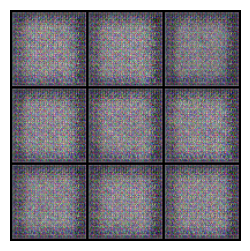

Checkpoint saved at: models/GAN/notumor/notumor_epoch_1_checkpoint.pkl
Epoch: 2/200 | Discriminator Loss: 0.9717 | Generator Loss: 3.9098 | D(x): 0.5770 | D(G(z)): 0.0972 / 0.0495


KeyboardInterrupt: 

In [27]:
training_loop(train_notumor_dataloader, 'notumor')

In [27]:
# increase the default limit set by Matplotlib for embedding animations
matplotlib.rcParams['animation.embed_limit'] = 100  # 100 MB

Epoch: 1/200 | Discriminator Loss: 0.4485 | Generator Loss: 3.8224 | D(x): 0.8100 | D(G(z)): 0.0343 / 0.0221


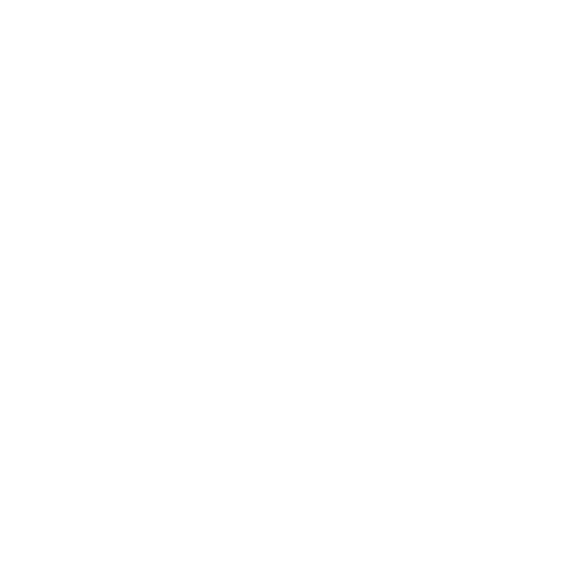

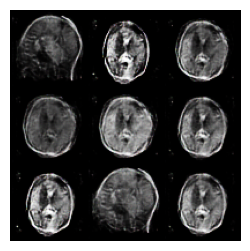

Checkpoint saved at: models/GAN/notumor/notumor_epoch_1_checkpoint.pkl
Epoch: 2/200 | Discriminator Loss: 0.4488 | Generator Loss: 4.7146 | D(x): 0.9072 | D(G(z)): 0.0471 / 0.0085
Epoch: 3/200 | Discriminator Loss: 0.4981 | Generator Loss: 4.1873 | D(x): 0.9210 | D(G(z)): 0.0835 / 0.0155


KeyboardInterrupt: 

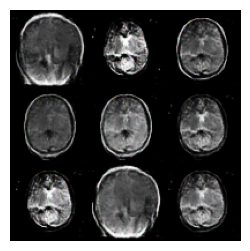

In [29]:
with open("data/img_lists/img_list_notumor.pkl", "rb") as f:
    img_list = pickle.load(f)

fig = plt.figure(figsize=(6, 6))
plt.axis("off")
plt.tight_layout(pad=2.0, h_pad=2.0, w_pad=2.0)

# Initial empty title and image
title = plt.title("")
img_plot = plt.imshow(np.transpose(img_list[0], (1, 2, 0)), animated=True)

def update_title_and_image(frame):
    img_plot.set_array(np.transpose(img_list[frame], (1, 2, 0)))
    title.set_text(f"Epoch {frame}/{num_epochs}")

ani = animation.FuncAnimation(fig, update_title_and_image, frames=len(img_list), interval=100, repeat_delay=5000)

# Display animation
HTML(ani.to_jshtml())

### Glioma loop

In [ ]:
training_loop(train_glioma_dataloader, 'glioma')

In [ ]:
with open("data/img_lists/img_list_glioma.pkl", "rb") as f:
    img_list = pickle.load(f)

fig = plt.figure(figsize=(6, 6))
plt.axis("off")
plt.tight_layout(pad=2.0, h_pad=2.0, w_pad=2.0)

# Initial empty title and image
title = plt.title("")
img_plot = plt.imshow(np.transpose(img_list[0], (1, 2, 0)), animated=True)

def update_title_and_image(frame):
    img_plot.set_array(np.transpose(img_list[frame], (1, 2, 0)))
    title.set_text(f"Epoch {frame}/{num_epochs}")

ani = animation.FuncAnimation(fig, update_title_and_image, frames=len(img_list), interval=100, repeat_delay=5000)

# Display animation
HTML(ani.to_jshtml())

In [ ]:
# Save the animation as a GIF
ani.save('other/gif/glioma/dcgan_training_animation.gif', writer='pillow')

### Meningioma loop

In [ ]:
training_loop(train_meningioma_dataloader, 'meningioma')

In [ ]:
with open("data/img_lists/img_list_meningioma.pkl", "rb") as f:
    img_list = pickle.load(f)

fig = plt.figure(figsize=(6, 6))
plt.axis("off")
plt.tight_layout(pad=2.0, h_pad=2.0, w_pad=2.0)

# Initial empty title and image
title = plt.title("")
img_plot = plt.imshow(np.transpose(img_list[0], (1, 2, 0)), animated=True)

def update_title_and_image(frame):
    img_plot.set_array(np.transpose(img_list[frame], (1, 2, 0)))
    title.set_text(f"Epoch {frame}/{num_epochs}")

ani = animation.FuncAnimation(fig, update_title_and_image, frames=len(img_list), interval=100, repeat_delay=5000)

# Display animation
HTML(ani.to_jshtml())

In [ ]:
# Save the animation as a GIF
ani.save('other/gif/meningioma/dcgan_training_animation.gif', writer='pillow')

### Pitulary loop

In [ ]:
training_loop(train_pituitary_dataloader, 'pituitary')

In [ ]:
with open("data/img_lists/img_list_pituitary.pkl", "rb") as f:
    img_list = pickle.load(f)

fig = plt.figure(figsize=(6, 6))
plt.axis("off")
plt.tight_layout(pad=2.0, h_pad=2.0, w_pad=2.0)

# Initial empty title and image
title = plt.title("")
img_plot = plt.imshow(np.transpose(img_list[0], (1, 2, 0)), animated=True)

def update_title_and_image(frame):
    img_plot.set_array(np.transpose(img_list[frame], (1, 2, 0)))
    title.set_text(f"Epoch {frame}/{num_epochs}")

ani = animation.FuncAnimation(fig, update_title_and_image, frames=len(img_list), interval=100, repeat_delay=5000)

# Display animation
HTML(ani.to_jshtml())

In [ ]:
# Save the animation as a GIF
ani.save('other/gif/pituitary/dcgan_training_animation.gif', writer='pillow')